# Homework 3
Section 8.3

Math 404

Winter 2020

<Name> Ethan Williams

In [15]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg as la

## Exercise 8.10
Add a method ``estimate`` to your ``LinearModel`` class to use the Kalman filter
to estimate a state sequence corresponding to a given observation sequence
``y`` and initial state estimate ``x0``. Your method should have this basic form:

In [197]:
%%capture
#Don't print out from this cell with %%capture
#Run the previous notebook, so we can start off where we left off.
%run hw82.ipynb

class LinearModel(LinearModel):
    def estimate(self,x0,P,y):
        """
        Compute the state estimates using the Kalman filter.
        If x0 and P correspond to time step k, then y is a sequence of
        observations starting at time step k+1.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        y : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        xk = x0
        pk = P
        est = []
        rinv = la.inv(self.R)
        for a in range(y.shape[1]):
            xk = self.F@xk + self.u
            pk = self.F@pk@self.F.T + self.Q
            pk = la.inv(la.inv(pk)+self.H.T@rinv@self.H)
            xk = xk - pk@self.H.T@rinv@(self.H@xk - y[:,a])
            est.append(xk.copy())
        return np.array(est).T
            

## Exercise 8.11
Returning to the projectile example, assume that the radar sensor has taken observations from time steps 200 through 800 (Take the corresponding slice of the observations produced in Exercise 8.8).

In [198]:
#Code for taking the slice goes here.
Q = np.eye(4)*.1
R = np.eye(2)*5000
F = np.eye(4)
F[0,2],F[1,3] = 0.1,0.1
u = np.array([0,0,0,-.98])
H = np.array([[1,0,0,0],[0,1,0,0]])

x0 = np.array([0,0,300,600])
projectile = LinearModel(F, Q, H, R, u)
states,observations = projectile.evolve(x0,1250)

sliced = (observations.T)[:,200:800]
print(sliced)

[[ 6057.52995217  6077.10269105  6136.82738256 ... 24009.04463715
  24080.64430462 24178.05766187]
 [10064.76579955  9960.35657306 10015.82471779 ... 16693.93797882
  16651.86556539 16511.77392167]]


Use these observations to estimate the corresponding true states of the projectile at those times.

### Part (i)
Construct an estimate $\widehat{\mathbf{x}}_200$ as follows: For the horizontal and vertical positions, simply use the observed position at time 200.  For the velocity, compute the average velocity between the observations $\mathbf{y}_k$ and $\mathbf{y}_{k+1}$ for $k = 200, \ldots, 208$, then average these 9 values and take this as the initial velocity estimate.

In [199]:
avg = np.diff((observations.T)[:,200:209])
velo = np.mean(avg*10,axis = 1)

xinit = np.concatenate(((observations.T)[:,200],velo))
print(xinit)

[ 6057.52995217 10064.76579955   221.25773785   276.78236403]


### Part (ii)
Use the initial accuracy estimate $P_{200} = 10^6 \cdot Q$ and feed $P_{200}$, $\widehat{\mathbf{x}}_{200}$, and $\mathbf{y}_{201}, \ldots, \mathbf{y}_{800}$ into the Kalman filter to obtain estimates $\widehat{\mathbf{x}}_{201}, \ldots, \widehat{\mathbf{x}}_{800}$.

In [200]:
P = projectile.Q*1000000
kalman = projectile.estimate(xinit,P,sliced)
print(kalman)

[[ 6058.57361976  6078.66408828  6117.66776821 ... 24125.43271182
  24153.11675412 24182.84592585]
 [10066.07137551 10021.66728804 10026.48045884 ... 16621.68425123
  16605.82167969 16586.18385095]
 [  219.17040267   215.9297639    268.41039823 ...   299.09085025
    298.76180586   298.74006585]
 [  273.19121212   144.96244014   114.79500247 ...  -172.76206848
   -173.53301687  -174.85085794]]


### Part (iii)
Plot these state estimates as a smooth green curve together with the radar observations (as red dots) and the entrire true state sequence (as a blue curve).

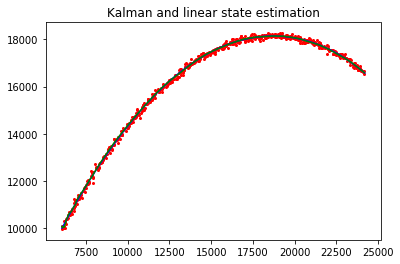

In [203]:
plt.plot([x[0] for x in states[200:800]],[x[1] for x in states[200:800]],'b')
plt.scatter([x[0] for x in observations[200:800]],[x[1] for x in observations[200:800]],s = 4,c = 'r')
plt.plot(kalman[0,:],kalman[1,:],'g')
plt.title("Kalman and linear state estimation")
plt.show()

Zoom in to see how well it follows the true path.  Your plots should be similar to Figure 8.3.

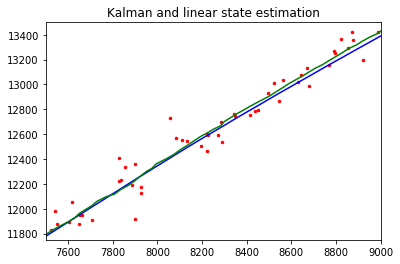

In [205]:
plt.plot([x[0] for x in states],[x[1] for x in states],'b')
plt.scatter([x[0] for x in observations],[x[1] for x in observations],s = 6,c = 'r')
plt.plot(kalman[0,:],kalman[1,:],'g')
plt.xlim((7500,9000))
plt.ylim((11750,13500))
plt.title("Kalman and linear state estimation")
plt.show()